<a href="https://colab.research.google.com/github/DeepankarAcharyya/Image_Segmentation/blob/main/Image_segmentation_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading the dataset:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [ ]:
%cd /content/gdrive/MyDrive/Projects-Misc/image_segmentation
!pwd

/content/gdrive/MyDrive/Projects-Misc/image_segmentation
/content/gdrive/MyDrive/Projects-Misc/image_segmentation


In [ ]:
!kaggle datasets download -d devdgohil/the-oxfordiiit-pet-dataset --force

100% 780M/780M [00:08<00:00, 81.2MB/s]
100% 780M/780M [00:08<00:00, 95.1MB/s]


In [ ]:
!unzip the-oxfordiiit-pet-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/images/Sphynx_9.jpg  
  inflating: images/images/Sphynx_90.jpg  
  inflating: images/images/Sphynx_91.jpg  
  inflating: images/images/Sphynx_92.jpg  
  inflating: images/images/Sphynx_93.jpg  
  inflating: images/images/Sphynx_94.jpg  
  inflating: images/images/Sphynx_95.jpg  
  inflating: images/images/Sphynx_96.jpg  
  inflating: images/images/Sphynx_98.jpg  
  inflating: images/images/Sphynx_99.jpg  
  inflating: images/images/american_bulldog_10.jpg  
  inflating: images/images/american_bulldog_100.jpg  
  inflating: images/images/american_bulldog_101.jpg  
  inflating: images/images/american_bulldog_102.jpg  
  inflating: images/images/american_bulldog_103.jpg  
  inflating: images/images/american_bulldog_104.jpg  
  inflating: images/images/american_bulldog_105.jpg  
  inflating: images/images/american_bulldog_106.jpg  
  inflating: images/images/american_bulldog_107.jpg  
  inflating: images/images/american

#Dataset Exploration and Preprocessing:

In [4]:
import os
from IPython.display import clear_output, Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

## List out the images and annotations:

In [5]:
base_dir='/content/gdrive/MyDrive/Projects-Misc/image_segmentation'
input_dir = os.path.join(base_dir,'images','images')
annotations_dir = os.path.join(base_dir,'annotations','annotations','trimaps')

In [6]:
input_images = os.listdir(input_dir)
target_annotations = os.listdir(annotations_dir)

In [7]:
images=[]
for eachfile in input_images:
  if eachfile.endswith('.jpg'):
    images.append(eachfile)

targets=[]
for eachfile in target_annotations:
  if eachfile.endswith('.png') and not eachfile.startswith("."):
    targets.append(eachfile)

### Mapping images to masks

In [8]:
images = sorted(images)
targets = sorted(targets)

In [9]:
print("No. of inputs:",len(images))
print("No. of masks:",len(targets))

No. of inputs: 7390
No. of masks: 7390


In [10]:
img_size = (160,160)
number_classes = 3

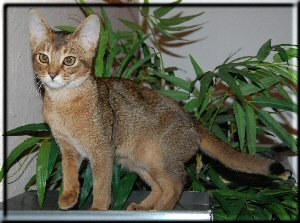

In [11]:
display(Image(os.path.join(input_dir,images[71])))

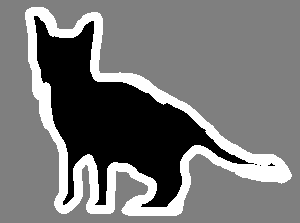

In [12]:
ImageOps.autocontrast(load_img(os.path.join(annotations_dir,targets[71])))

## Preprocessing Opts: Creating a preprocessing pipe-line

In [13]:
from tensorflow import keras as k
import numpy as np

In [14]:
class image_preprocessing(k.utils.Sequence):
  def __init__(self, batch_size, img_size, input_images, target_images, input_dir, target_dir):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_dir = input_dir
    self.target_dir = target_dir
    self.input_images = input_images 
    self.target_images = target_images
  
  def __len__(self):
    return len(self.target_images)//self.batch_size

  def __getitem__(self, index):
    i = index*self.batch_size
    batch_inputs = self.input_images[i : i+self.batch_size]
    batch_targets = self.target_images[i : i+self.batch_size]

    x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype ="float32")
    for j, path in enumerate(batch_inputs):
      img = load_img(os.path.join(self.input_dir,path), target_size = self.img_size)
      x[j] = img
    
    y = np.zeros((self.batch_size,)+self.img_size+(1,), dtype ="uint8")
    for j, path in enumerate(batch_targets):
      img=load_img(os.path.join(self.target_dir,path), target_size=self.img_size, color_mode="grayscale")
      y[j] = np.expand_dims(img, 2)
      y[j] -= 1
    return x,y

##Defining the model:


In [15]:
def down_block(x, filters, kernel_size=(3,3), padding="same", strides=1):
  c = k.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
  c = k.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
  p = k.layers.MaxPool2D((2,2),(2,2))(c)
  return c,p

def up_block(x,skip, filters, kernel_size=(3,3), padding="same", strides=1):
  u = k.layers.UpSampling2D((2,2))(x)
  s = k.layers.Concatenate()([u,skip])
  c = k.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(s)
  c = k.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
  return c

def bottleneck(x, filters, kernel_size=(3,3), padding="same", strides=1):
  c = k.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, activation="relu")(x)
  c = k.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, activation="relu")(c)
  return c

In [16]:
def create_unet_model(image_size):
  f = [64, 128, 256, 512, 1024]

  inputs = k.layers.Input((image_size, image_size, 3))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0])
  c2, p2 = down_block(p1, f[1])
  c3, p3 = down_block(p2, f[2])
  c4, p4 = down_block(p3, f[3])

  bn = bottleneck(p4, f[4])

  u1 = up_block(bn, c4, f[3])
  u2 = up_block(u1, c3, f[2])
  u3 = up_block(u2, c2, f[1])
  u4 = up_block(u3, c1, f[0])

  outputs = k.layers.Conv2D(1, (1,1) ,padding="same", activation="sigmoid")(u4)
  final_model = k.models.Model(inputs, outputs)
  return final_model

In [23]:
model = create_unet_model(128)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

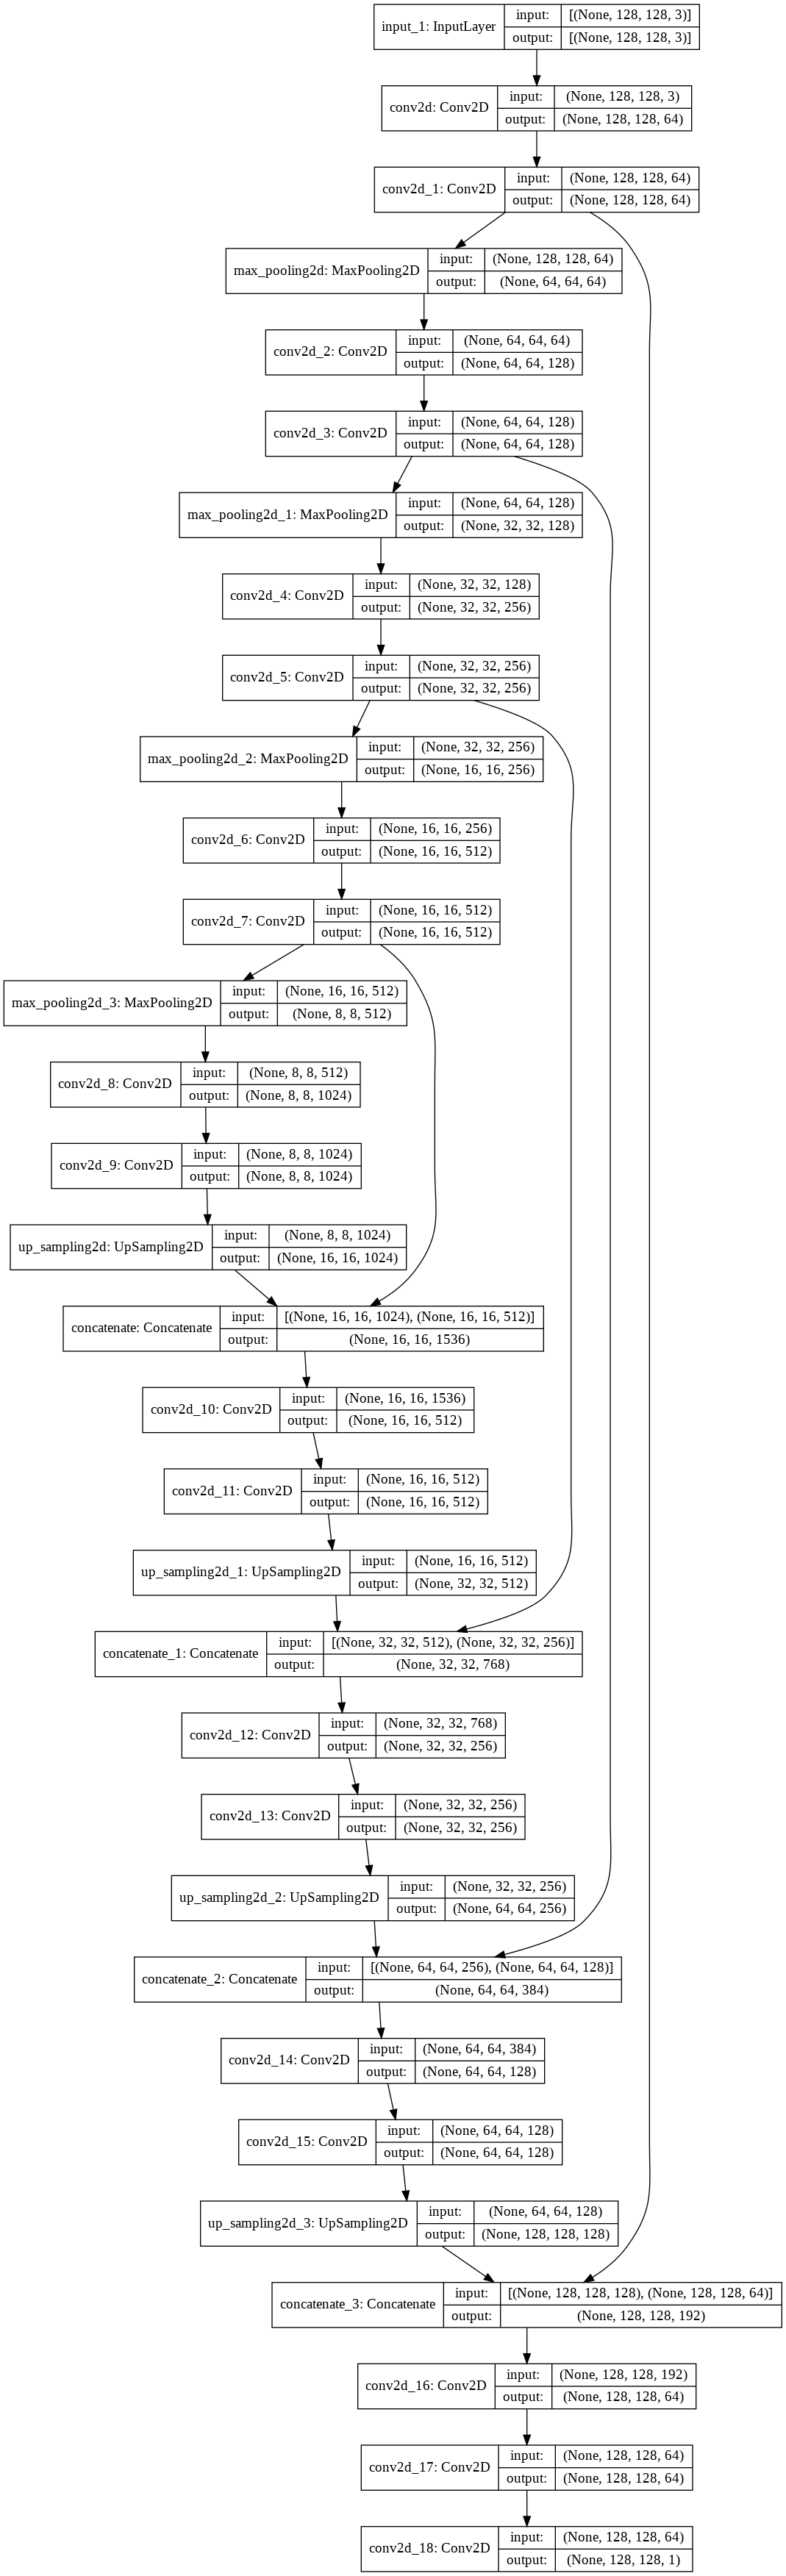

In [17]:
k.utils.plot_model(model, show_shapes=True)

### Splitting the dataset:

In [18]:
import random

In [19]:
val_size = 1000
seed = 2020
random.Random(seed).shuffle(images)
random.Random(seed).shuffle(targets)

train_input = images[:-val_size]
train_output = targets[:-val_size]

val_input = images[-val_size:]
val_output = targets[-val_size:]

## Creating the training and validation generators:

In [20]:
train_gen = image_preprocessing(batch_size=32, img_size=(128,128), input_images=train_input, target_images=train_output, input_dir=input_dir, target_dir=annotations_dir)
val_gen   = image_preprocessing(batch_size=32, img_size=(128,128), input_images=val_input, target_images=val_output, input_dir=input_dir, target_dir=annotations_dir)

## Callbacks:

In [21]:
callbacks =[k.callbacks.ModelCheckpoint(os.path.join(base_dir,"image_seg.h5"),save_best_only=True)]

### Training the model:

In [ ]:
history = model.fit(train_gen, epochs = 15, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
  7/199 [>.............................] - ETA: 31:18 - loss: nan - acc: 0.3083

## Analyzing the loss:

In [ ]:
loss = history['']